# 05 - Different Anomaly Detection Algorithms

This tutorial will show different approaches other than deep learning that can be applied to search for anomalies. All the techniques is readily available in Scikit-learn library. By the end of this tutorial, you will be able to:

1. Prepare dataset to be feed into anomaly detection algorithms
2. Apply different anomaly detection algorithms readily accessible from Scikit-learn API
3. Compare and contrast performance of anomaly detection algorithms

Below is the outline for this tutorial:
1. [A Little Bit of Theory](#theory)
2. [Choice of Dataset](#dataset)
3. [Baseline Performance](#baseline)
4. [Anomaly Detection Techniques](#techniques) 
    * a) [Isolation Forest](#isolation-forest)
    * b) [Minimum Covariance Determinant](#minimum-cov-determinant)
    * c) [Local Outlier Factor (LOF)](#lof)
    * d) [One-class Support Vector Machine (OCSVM)](#ocsvm)
5. [Reference](#reference)


### <a name="theory"></a>A Little Bit of Theory
Anomalies (or outliers) are observations that vary significantly in terms of their features compared to majority of observations in the data.

An illustrative example will be when we plot a histogram, they will usually be far from the rest of the observations or the center of mass of observations. Nevertheless, manually identifying an anomaly becomes very challenging when there are many features (high-dimensional input feature space).

High-dimensional dataset makes it impossible to perform anomaly detection using conventional statistical methods like standard deviations or interquartile range (IQR). 

Perhaps, we should discuss why anomaly detection is important. Presence of anomalies will skew statistical measures and data distributions. This means that the underlying data distributions could be markedly different from what is observed. Identifying and removing outliers from training data will make the training data to have a more resemblance to the actual underlying data, thus results in better model and predictions.

There are different techniques for anomalies detection that is readily available that can be applied by calling the API. These techniques approach the problem of anomaly detection from different perspectives. This means that we have a variety of approaches in anomaly detection, which we can choose according to our needs and objectives.

Enough of theory, let's kick start the tutorial.


## <a name="dataset">Choice of Dataset</a>
We would be using the Boston Housing Dataset to be our regression example. This dataset is obtained from https://www.kaggle.com/vikrishnan/boston-house-prices
The description of the attributes:
* CRIM: Per capita crime rate by town
* ZN: Proportion of residential land zoned for lots over 25,000 sq. ft
* INDUS: Proportion of non-retail business acres per town
* CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX: Nitric oxide concentration (parts per 10 million)
* RM: Average number of rooms per dwelling
* AGE: Proportion of owner-occupied units built prior to 1940
* DIS: Weighted distances to five Boston employment centers
* RAD: Index of accessibility to radial highways
* TAX: Full-value property tax rate per \$10,000
* PTRATIO: Pupil-teacher ratio by town
* B: 1000(Bk — 0.63)², where Bk is the proportion of [people of African American descent] by town
* LSTAT: Percentage of lower status of the population
* MEDV: Median value of owner-occupied homes in $1000s (target variable)

The dataset has many numerical input variables that have unknown and complex relationships. We don’t know that outliers exist in this dataset, although we may guess that some outliers may be present.

The example below loads the dataset and splits it into the input and output columns, splits it into train and test datasets, then summarizes the shapes of the data arrays.



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import sys

# configure random state for reproducibility
seed = 1

In [2]:
col_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 
             'PTRAIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv("../datasets/boston/BostonHousing.csv", header=None, names=col_names)

# split into input and output elements
X, y = df.iloc[:, :-1], df.iloc[:, -1]
# summarize the shape of the dataset
print(X.shape, y.shape)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

# let's sort them by index
X_train, y_train = X_train.sort_index(), y_train.sort_index()
X_test, y_test = X_train.sort_index(), y_train.sort_index()

# we also need a model for anomaly detection model training usage consisting of features and labels (unsupervised)
unsupervised_data = pd.concat([X_train, y_train], axis=1)

# summarize the shape of the train and test sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(506, 13) (506,)
(339, 13) (339, 13) (339,) (339,)


Running above cell results shows that there are 506 rows of data with 13 features and 1 target.

The dataset is then split into train and test sets with 339 observations as training set and 167 for testing set (we will skip the validation phase as this is a tutorial to showcase ability of different anomaly detection techniques).

We will then establish establish a baseline to compare performance of different models.

## <a name="baseline">Baseline Performance</a>

"It is a regression predictive modeling problem, meaning that we will be predicting a numeric value. All input variables are also numeric.

In this case, we will fit a linear regression algorithm and evaluate model performance by training the model on the test dataset and making a prediction on the test data and evaluate the predictions using the mean absolute error (MAE).

The complete example of evaluating a linear regression model on the dataset is listed below."

In [3]:
# fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# evaluate the model
preds = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, preds)
print('MAE: %.3f' % mae)

MAE: 3.279


We can see that prior to any anomaly detection and removal, a simple linear regression model has managed to achieve a MAE of 3.279. Let's try to do better by removing anomalies.

## <a name=techniques>Anomaly Detection Techniques</a>

The scikit-learn library provides a number of built-in automatic methods for identifying outliers in data.

In this section, we will review four methods and compare their performance on the house price dataset.

Each method will be defined, then fit on the training dataset. The fit model will then predict which examples in the training dataset are outliers and which are not (so-called inliers). The outliers will then be removed from the training dataset, then the model will be fit on the remaining examples and evaluated on the entire test dataset.

It would be invalid to fit the outlier detection method on the entire training dataset as this would result in data leakage. That is, the model would have access to data (or information about the data) in the test set not used to train the model. This may result in an optimistic estimate of model performance.

We could attempt to detect outliers on “new data” such as the test set prior to making a prediction, but then what do we do if outliers are detected?

One approach might be to return a “None” indicating that the model is unable to make a prediction on those outlier cases. This might be an interesting extension to explore that may be appropriate for your project.

### <a name=isolation-forest>a) Isolation Forest</a>

```
Isolation Forest, or iForest for short, is a tree-based anomaly detection algorithm.

It is based on modeling the normal data in such a way as to isolate anomalies that are both few in number and different in the feature space.
```

```
… our proposed method takes advantage of two anomalies’ quantitative properties: i) they are the minority consisting of fewer instances and ii) they have attribute-values that are very different from those of normal instances.
```

— Isolation Forest, 2008.

The scikit-learn library provides an implementation of Isolation Forest in the [IsolationForest class](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html).

Perhaps the most important hyperparameter in the model is the “contamination” argument, which is used to help estimate the number of outliers in the dataset. This is a value between 0.0 and 0.5 and by default is set to 0.1.

<AxesSubplot:>

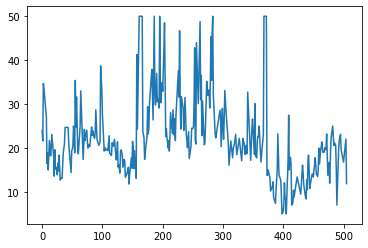

In [4]:
y_train.plot(kind='line')

In [5]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1)
# yhat = iso.fit_predict(X_train) # without using the target variable, the performance actually dropped
yhat = iso.fit_predict(unsupervised_data)

Once fit the algorithm and made predictions, we can identify which observations are classified as anomalies by our algorithm.

Indices of anomaly samples: (array([ 99, 100, 105, 107, 108, 109, 113, 135, 137, 141, 142, 177, 180,
       182, 190, 191, 193, 194, 199, 200, 237, 238, 239, 241, 244, 245,
       247, 249, 251, 272, 275, 277, 279, 283], dtype=int64),)
144    11.8
145    13.8
152    15.3
154    17.0
155    15.6
Name: MEDV, dtype: float64


<Figure size 1008x648 with 0 Axes>

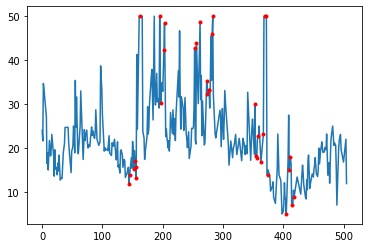

In [6]:
# identify which of the observations are classified as anomalies by algorithm
anomalies_indices = yhat == -1
print(f"Indices of anomaly samples: {np.where(anomalies_indices)}")

print(y_train.iloc[anomalies_indices][:5])

# overlaying inaccuracte predictions on test closing price chart
plt.figure(figsize=(14, 9))
df_subset = y_train.iloc[anomalies_indices]
fig, ax = plt.subplots()
y_train.plot(legend=False, ax=ax)
df_subset.plot(style='.', legend=False, ax=ax, color="r")
plt.show()

Let's then remove these outliers and fit our linear regression model again and evaluate its performance.

In [7]:
# removing anomalies
mask = yhat != -1
X_train_processed, y_train_processed = X_train.loc[mask, :], y_train.loc[mask]
# summarize the shape of the updated training dataset
print(X_train_processed.shape, y_train_processed.shape)
# fit the model
model = LinearRegression()
model.fit(X_train_processed, y_train_processed)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

(305, 13) (305,)
MAE: 3.176


In this case, we can see that that model identified and removed 34 outliers and achieved a MAE of about 3.189, an improvement over the baseline that achieved a score of about 3.417.

### <a name=minimum-cov-determinant>b) Minimum Covariance Determinant </a>

If the input variables have a Gaussian distribution, then simple statistical methods can be used to detect outliers.

For example, if the dataset has two input variables and both are Gaussian, then the feature space forms a multi-dimensional Gaussian and knowledge of this distribution can be used to identify values far from the distribution.

This approach can be generalized by defining a hypersphere (ellipsoid) that covers the normal data, and data that falls outside this shape is considered an outlier. An efficient implementation of this technique for multivariate data is known as the Minimum Covariance Determinant, or MCD for short.

```
The Minimum Covariance Determinant (MCD) method is a highly robust estimator of multivariate location and scatter, for which a fast algorithm is available. […] It also serves as a convenient and efficient tool for outlier detection.
```
— Minimum Covariance Determinant and Extensions, 2017.

The scikit-learn library provides access to this method via the [EllipticEnvelope class](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html).

It provides the “contamination” argument that defines the expected ratio of outliers to be observed in practice. In this case, we will set it to a value of 0.01, found with a little trial and error.

In [8]:
# identify outliers in the training dataset
ee = EllipticEnvelope(contamination=0.01)
yhat = ee.fit_predict(unsupervised_data)

Once fit the algorithm and made predictions, we can identify which observations are classified as anomalies by our algorithm.

Indices of anomaly samples: (array([272, 275, 279, 283], dtype=int64),)
405     5.0
410    15.0
414     7.0
418     8.8
Name: MEDV, dtype: float64


<Figure size 1008x648 with 0 Axes>

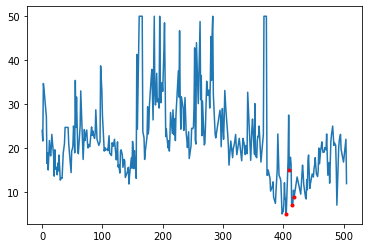

In [9]:
# identify which of the observations are classified as anomalies by algorithm
anomalies_indices = yhat == -1
print(f"Indices of anomaly samples: {np.where(anomalies_indices)}")

print(y_train.iloc[anomalies_indices][:5])

# overlaying inaccuracte predictions on test closing price chart
plt.figure(figsize=(14, 9))
df_subset = y_train.iloc[anomalies_indices]
fig, ax = plt.subplots()
y_train.plot(legend=False, ax=ax)
df_subset.plot(style='.', legend=False, ax=ax, color="r")
plt.show()

In [10]:
# removing anomalies
mask = yhat != -1
X_train_processed, y_train_processed = X_train.loc[mask, :], y_train.loc[mask]
# summarize the shape of the updated training dataset
print(X_train_processed.shape, y_train_processed.shape)
# fit the model
model = LinearRegression()
model.fit(X_train_processed, y_train_processed)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

(335, 13) (335,)
MAE: 3.285


The elliptical envelope method identified and removed just 4 anomalies. The resultant linear regression model has more or less the same MAE compared to original training set.

### <a name=lof>c) Local Outlier Factor</a>

A simple approach to identifying outliers is to locate those examples that are far from the other examples in the feature space.

This can work well for feature spaces with low dimensionality (few features), although it can become less reliable as the number of features is increased, referred to as the curse of dimensionality.

The local outlier factor, or LOF for short, is a technique that attempts to harness the idea of nearest neighbors for outlier detection. Each example is assigned a scoring of how isolated or how likely it is to be outliers based on the size of its local neighborhood. Those examples with the largest score are more likely to be outliers.

```
We introduce a local outlier (LOF) for each object in the dataset, indicating its degree of outlier-ness.
```
— LOF: Identifying Density-based Local Outliers, 2000.

The scikit-learn library provides an implementation of this approach in the [LocalOutlierFactor class](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

The model provides the “contamination” argument, that is the expected percentage of outliers in the dataset, be indicated and defaults to 0.1.

In [11]:
# identify outliers in the training dataset
lof = LocalOutlierFactor()
yhat = lof.fit_predict(unsupervised_data)

Once fit the algorithm and made predictions, we can identify which observations are classified as anomalies by our algorithm.

Indices of anomaly samples: (array([ 17,  19,  22,  37,  86,  92, 100, 106, 108, 109, 115, 200, 237,
       244, 246, 247, 248, 249, 258, 266, 271, 272, 273, 278, 297, 301,
       306, 308, 313, 316, 320, 322, 326, 327, 328, 329, 330, 331],
      dtype=int64),)
25     13.9
27     14.8
32     13.2
54     18.9
126    15.7
Name: MEDV, dtype: float64


<Figure size 1008x648 with 0 Axes>

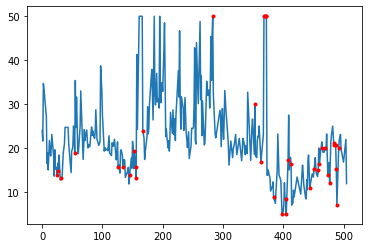

In [12]:
# identify which of the observations are classified as anomalies by algorithm
anomalies_indices = yhat == -1
print(f"Indices of anomaly samples: {np.where(anomalies_indices)}")

print(y_train.iloc[anomalies_indices][:5])

# overlaying inaccuracte predictions on test closing price chart
plt.figure(figsize=(14, 9))
df_subset = y_train.iloc[anomalies_indices]
fig, ax = plt.subplots()
y_train.plot(legend=False, ax=ax)
df_subset.plot(style='.', legend=False, ax=ax, color="r")
plt.show()

In [13]:
# removing anomalies
mask = yhat != -1
X_train_processed, y_train_processed = X_train.loc[mask, :], y_train.loc[mask]
# summarize the shape of the updated training dataset
print(X_train_processed.shape, y_train_processed.shape)
# fit the model
model = LinearRegression()
model.fit(X_train_processed, y_train_processed)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

(301, 13) (301,)
MAE: 3.159


In this case, we can see that the local outlier factor method identified and removed 38 anomalies. It also has a beter MAE of 3.159. 

### <a name=ocsvm> d) One-Class SVM (OCSVM)</a>

The support vector machine, or SVM, algorithm developed initially for binary classification can be used for one-class classification.

When modeling one class, the algorithm captures the density of the majority class and classifies examples on the extremes of the density function as outliers. This modification of SVM is referred to as One-Class SVM.

```
… an algorithm that computes a binary function that is supposed to capture regions in input space where the probability density lives (its support), that is, a function such that most of the data will live in the region where the function is nonzero.
```
— Estimating the Support of a High-Dimensional Distribution, 2001.

Although SVM is a classification algorithm and One-Class SVM is also a classification algorithm, it can be used to discover outliers in input data for both regression and classification datasets.

The scikit-learn library provides an implementation of one-class SVM in the [OneClassSVM class](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html).

The class provides the “nu” argument that specifies the approximate ratio of outliers in the dataset, which defaults to 0.1. In this case, we will set it to 0.01, found with a little trial and error.

In [14]:
# identify outliers in the training dataset
ee = OneClassSVM(nu=0.01)
yhat = ee.fit_predict(unsupervised_data)

Once fit the algorithm and made predictions, we can identify which observations are classified as anomalies by our algorithm.

Indices of anomaly samples: (array([237, 275, 300, 331], dtype=int64),)
353    30.1
410    15.0
450    13.4
492    20.1
Name: MEDV, dtype: float64


<Figure size 1008x648 with 0 Axes>

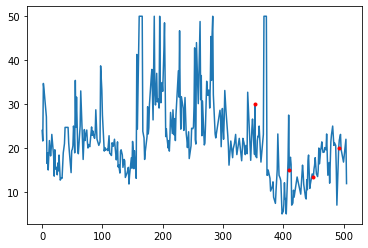

In [15]:
# identify which of the observations are classified as anomalies by algorithm
anomalies_indices = yhat == -1
print(f"Indices of anomaly samples: {np.where(anomalies_indices)}")

print(y_train.iloc[anomalies_indices][:5])

# overlaying inaccuracte predictions on test closing price chart
plt.figure(figsize=(14, 9))
df_subset = y_train.iloc[anomalies_indices]
fig, ax = plt.subplots()
y_train.plot(legend=False, ax=ax)
df_subset.plot(style='.', legend=False, ax=ax, color="r")
plt.show()

In [16]:
# removing anomalies
mask = yhat != -1
X_train_processed, y_train_processed = X_train.loc[mask, :], y_train.loc[mask]
# summarize the shape of the updated training dataset
print(X_train_processed.shape, y_train_processed.shape)
# fit the model
model = LinearRegression()
model.fit(X_train_processed, y_train_processed)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, yhat)
print('MAE: %.3f' % mae)

(335, 13) (335,)
MAE: 3.289


The MAE from OCSVM has not much difference compared to prior removal of anomalies. This might indicates that this algorithm has not effectively identified the actual anomalies.

## <a name=reference>Reference </a>:
1. [Isolation Forest](https://ieeexplore.ieee.org/abstract/document/4781136), 2008
2. [Minimum Covariance Determinant and Extensions](https://arxiv.org/abs/1709.07045), 2017
3. [LOF: Identifying Density-based Local Outliers](https://dl.acm.org/doi/10.1145/342009.335388), 2000
4. [Estimating the Support of a High-Dimensional Distribution](https://dl.acm.org/doi/10.1162/089976601750264965), 2001
5. [4 Automatic Outlier Detection Algorithms in Python](https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/) by Jason Brownlee
6. [2.7. Novelty and Outlier Detection](https://scikit-learn.org/stable/modules/outlier_detection.html)
7. https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e